In [1]:
%matplotlib inline
import velocyto as vcy
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
from copy import deepcopy
import pickle
from velocity_helper import VelocityHelper
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

/home/smudge/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/smudge/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/home/smudge/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 1: 
  warnings.warn(x, RRuntimeWarning)
/home/smudge/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: In value[[3L]](cond) :
  warnings.warn(x, RRuntimeWarning)
/home/smudge/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
 
  warnings.warn(x, RRuntimeWarning)
/home/smudge/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRu

## Things to do:

* Get velocity helper to be useful lol
* Figure out how to compute the velocity value for each cell. I thought that I had done this but the data does not look right when compared to the velocituy tsne.

* Check if velocity (or speed) of a cell correlates with number of genes expressed or nUMI in that cell.

* Fully process all samples, save and organize plots.
    * raw velocity tsne
    * averaged velocity tsne
    * cell type cluster label tsne
    * marker gene plots
    * pseudotime
    * zoom in on interesting areas
    * ratio of spliced / unspliced transcripts
    * velocity magnitude
    
* Why are there stromal cells in these data?

In [222]:
#load ind4
ind2 = pickle.load(open("/home/smudge/Documents/kessenbrock_lab/RNA_velocity/ind4/ind4.hdf5", 'rb'))


In [224]:
ind = "ind4"
print_dir = "/home/smudge/Documents/kessenbrock_lab/RNA_velocity/figures/{}/".format(ind)

In [201]:
vh = VelocityHelper()
#cell_type_file = "/home/smudge/Documents/kessenbrock_lab/RNA_velocity/ind2_celltypes.tsv"
#marker_gene_file = "/home/smudge/Documents/kessenbrock_lab/RNA_velocity/ind2/ind2_marker_genes_trim.txt"

In [202]:
metadata = pd.read_table("/home/smudge/Documents/kessenbrock_lab/RNA_velocity/Norm.BRCA.Combined.Seurat.Meta.Data.Object.txt")
metadata.set_index("barcode", inplace=True)

In [203]:
#load loom files for all inds:
ind2 = vcy.VelocytoLoom("/home/smudge/Documents/kessenbrock_lab/RNA_velocity/rna_velocity_data/ind10/possorted_genome_bam_DZN3A.loom")

#fix barcodes:
ind2.ca['CellID'] = np.array([b.split(":")[1] for b in ind2.ca["CellID"]])

In [204]:
ind2.S.shape

(58676, 12362)

In [205]:
# remove cells with extremely low unspliced detection
ind2.filter_cells(bool_array=ind2.initial_Ucell_size > np.percentile(ind2.initial_Ucell_size, 0.5))

In [206]:
cell_id_dict = {barcode.split("_")[1]: metadata[metadata["individual"] == ind]["individual.analysis.idents"][barcode] for barcode in list(metadata[metadata["individual"] == ind].index)}
barcode_bool = np.array([True if barcode in cell_id_dict.keys() else False for barcode in ind2.ca['CellID']])
clusternames = np.array([cell_id_dict[barcode] for barcode in ind2.ca['CellID'] if barcode in cell_id_dict.keys()])

In [207]:
#filter out cells that are not found in the metadata df
ind2.filter_cells(bool_array = np.array(barcode_bool))
ind2.ca["ClusterName"] = clusternames

In [208]:
#get rid of stromal cell types:
stromal_filter = np.array([False if "stromal" in cell_type else True for cell_type in ind2.ca["ClusterName"]])
ind2.filter_cells(bool_array=stromal_filter)

In [209]:
ind2.S.shape

(58676, 9240)

In [210]:
#set clusters to cell type, defined previously
ind2.set_clusters(ind2.ca["ClusterName"])

#filter out cells that are in the "unknown" cluster:
ind2.filter_cells(bool_array = np.array([True if cell_id_dict[barcode] != "Unknown" else False for barcode in ind2.ca["CellID"]]))


In [211]:
ind2.score_detection_levels(min_expr_counts=40, min_cells_express=30)
ind2.filter_genes(by_detection_levels=True)

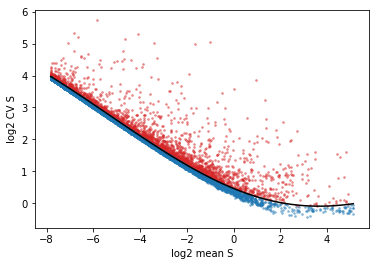

In [212]:
#feature selection:
#ind2.score_cv_vs_mean(3000, plot=True, max_expr_avg=35)
ind2.score_cv_vs_mean(3000, plot=True, max_expr_avg=35)
ind2.filter_genes(by_cv_vs_mean=True)
plt.savefig(print_dir + "feature_selection.pdf")

In [213]:
#normalize data by total molecule count
ind2._normalize_S(relative_size=ind2.S.sum(0), target_size=ind2.S.sum(0).mean())
ind2._normalize_U(relative_size=ind2.U.sum(0), target_size=ind2.U.sum(0).mean())

In [214]:
# run pca and k-nearest-neighbors
ind2.perform_PCA()
ind2.knn_imputation(n_pca_dims=20, k=500, balanced=True, b_sight=1000, b_maxl=1500, n_jobs=16)
#ind2.knn_imputation(n_pca_dims=20, k=500, balanced=True, b_sight=3000, b_maxl=1500, n_jobs=16)

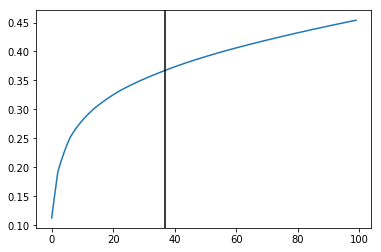

In [215]:
plt.plot(np.cumsum(ind2.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(ind2.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")


In [216]:
ind2.fit_gammas(limit_gamma=False, fit_offset=False)

In [217]:
ind2.predict_U()
ind2.calculate_velocity()
ind2.calculate_shift(assumption="constant_velocity")
ind2.extrapolate_cell_at_t(delta_t=1.)

In [218]:
bh_tsne = TSNE()
ind2.ts = bh_tsne.fit_transform(ind2.pcs[:, :25])


In [219]:
ind2.estimate_transition_prob(hidim="Sx_sz", embed="ts", transform="sqrt", psc=1,
                             n_neighbors=1000, knn_random=True, sampled_fraction=0.5)
ind2.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=True)

# ind2.estimate_transition_prob(hidim="Sx_sz", embed="ts", transform="sqrt", psc=1,
#                              n_neighbors=3500, knn_random=True, sampled_fraction=0.5)
# ind2.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=True)

### Write Unspliced & Spliced counts matrices to files

In [225]:
#gene list
with open("/home/smudge/Documents/kessenbrock_lab/RNA_velocity/data/{}/{}_genes.txt".format(ind, ind), 'w') as f:
    for gene in ind2.ra["Gene"]:
        f.write(gene + "\n")

In [226]:
#Unspliced:
u_df = pd.DataFrame(ind2.U, index=ind2.ra['Gene'], columns=ind2.ca['CellID'])
u_df.to_csv("/home/smudge/Documents/kessenbrock_lab/RNA_velocity/data/{}/{}_unspliced_counts.tsv".format(ind,ind), sep="\t")

#Spliced
s_df = pd.DataFrame(ind2.S, index=ind2.ra['Gene'], columns=ind2.ca['CellID'])
s_df.to_csv("/home/smudge/Documents/kessenbrock_lab/RNA_velocity/data/{}/{}_spliced_counts.tsv".format(ind,ind), sep="\t")

#velocity
v_df = pd.DataFrame(ind2.velocity, index=ind2.ra['Gene'], columns=ind2.ca['CellID'])
v_df.to_csv("/home/smudge/Documents/kessenbrock_lab/RNA_velocity/data/{}/{}_velocity.tsv".format(ind,ind), sep="\t")



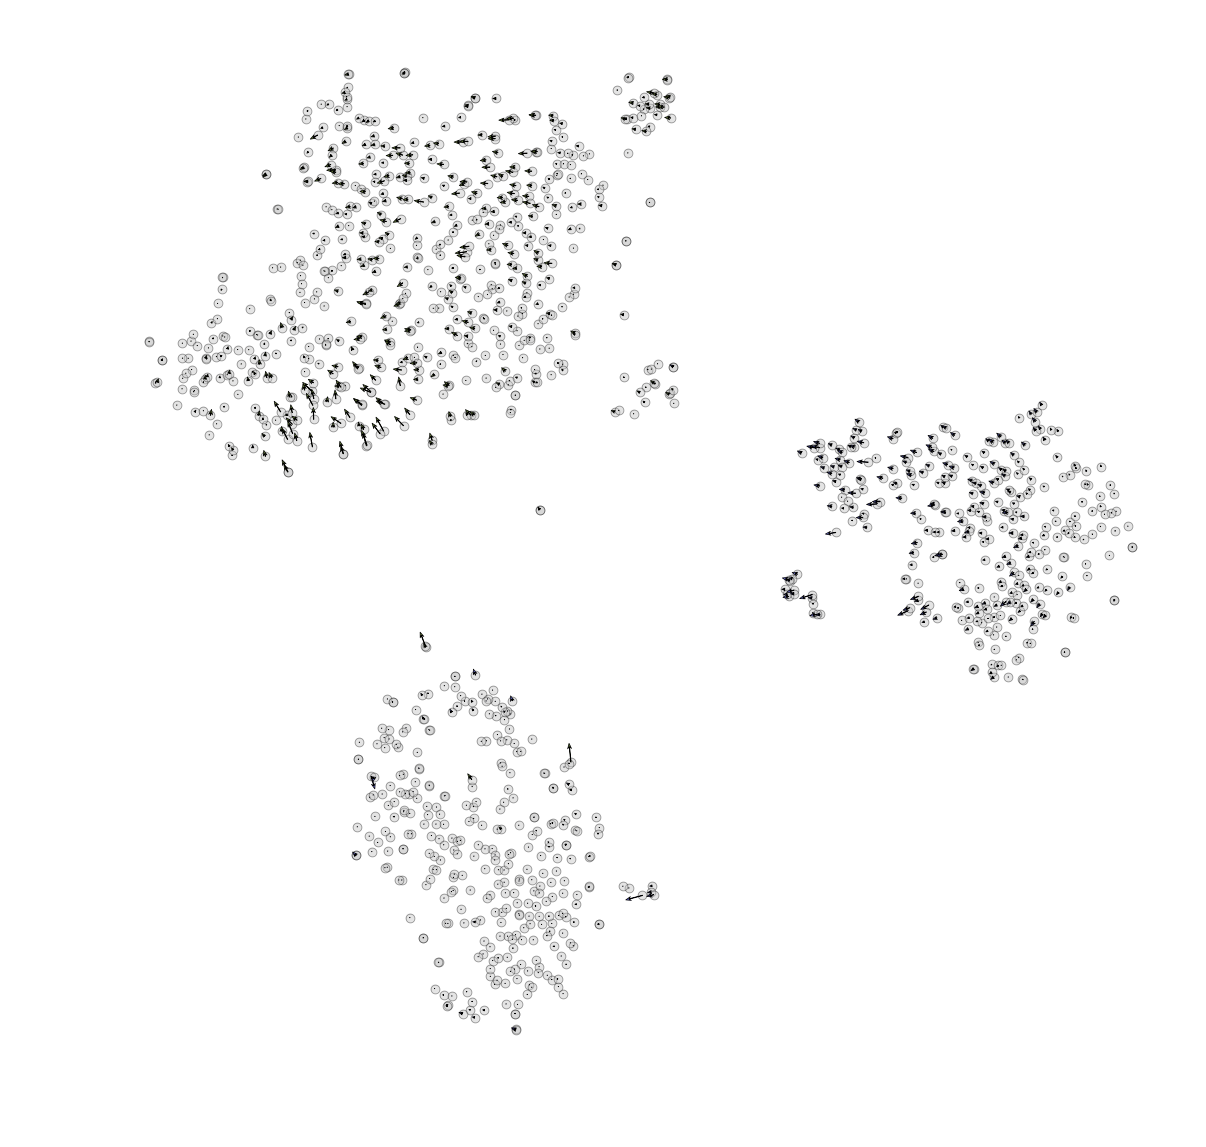

In [327]:
#ind2
f, ax = plt.subplots(1,1, figsize=(7,7),dpi=200)
plt.subplot(111)
quiver_scale = 25
plt.scatter(ind2.embedding[:, 0], ind2.embedding[:, 1],
            c="0.8", alpha=0.2, s=10, edgecolor="")

ix_choice = np.random.choice(ind2.embedding.shape[0], size=int(ind2.embedding.shape[0]/1.), replace=False)
plt.scatter(ind2.embedding[ix_choice, 0], ind2.embedding[ix_choice, 1],
            c="0.8", alpha=0.4, s=10, edgecolor=(0,0,0,1), lw=0.3, rasterized=True)

quiver_kwargs=dict(headaxislength=7, headlength=11, headwidth=8,linewidths=0.25, width=0.00045,edgecolors="k", color=ind2.colorandum[ix_choice], alpha=1)
plt.quiver(ind2.embedding[ix_choice, 0], ind2.embedding[ix_choice, 1],
           ind2.delta_embedding[ix_choice, 0], ind2.delta_embedding[ix_choice, 1],
           scale=quiver_scale, **quiver_kwargs)
plt.axis("off");
plt.savefig(print_dir + "raw_velocity.pdf")

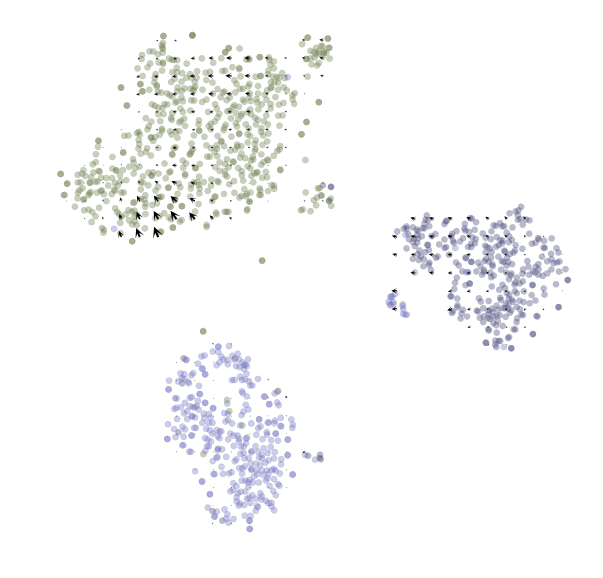

In [328]:
#ind2
#velocity tsne
ind2.calculate_grid_arrows(smooth=0.8, steps=(30, 30), n_neighbors=300)
f, ax = plt.subplots(1,1, figsize=(10,10))
#ax1 = plt.subplot(121)
ind2.plot_grid_arrows(quiver_scale=0.10,
                    scatter_kwargs_dict={"alpha":0.35, "lw":0.35, "edgecolor":"0.4", "s":38, "rasterized":True}, min_mass=1, angles='xy', scale_units='xy',
                    headaxislength=2.75, headlength=5, headwidth=4.8, minlength=0.35,
                    plot_random=False, scale_type='absolute')

plt.axis("off");
plt.savefig(print_dir + "average_velocity.pdf")  

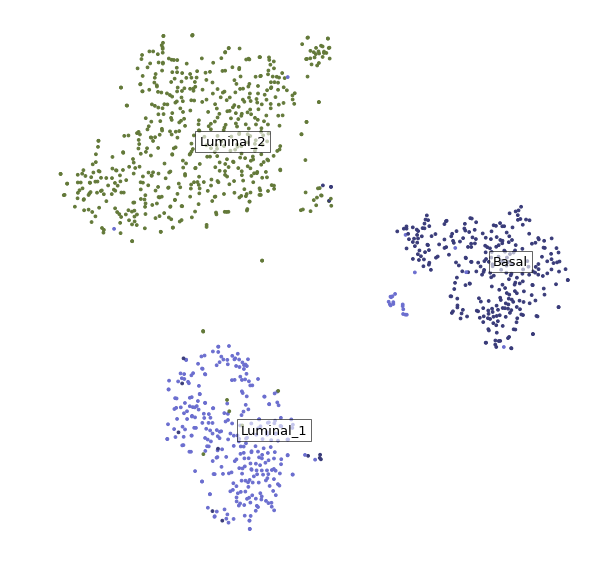

In [329]:
#tsne with cluster names
f, ax = plt.subplots(1,1, figsize=(10,10))
vcy.scatter_viz(ind2.ts[:,0], ind2.ts[:,1], c=ind2.colorandum, s=7.5)
#vcy.scatter_viz(ind2.ts[:,0], ind2.ts[:,1], c=mycolors, s=7.5)

for i in list(set(ind2.ca["ClusterName"])):
    ts_m = np.median(ind2.ts[ind2.ca["ClusterName"] == i, :], 0)
    plt.text(ts_m[0], ts_m[1], str(ind2.cluster_labels[ind2.ca["ClusterName"] == i][0]),
             fontsize=13, bbox={"facecolor":"w", "alpha":0.6}) 
plt.axis("off");
plt.savefig(print_dir + "tsne_celltypes.pdf")  

# Velocity Magnitudes

In [330]:
#unique_data = [list(x) for x in set(tuple(x) for x in testdata)]
mycolors = [list(thing) for thing in set(tuple(x) for x in ind2.colorandum)]
mycolors = [mycolors[1], mycolors[2], mycolors[0]]

In [331]:
ind2_splice_dict = {cl: defaultdict(list) for cl in list(set(ind2.ca["ClusterName"]))}
for cluster in list(set(ind2.ca["ClusterName"])):
    for i in range(ind2.S.T[ind2.ca['ClusterName'] == cluster].T.shape[1]):
        ind2_splice_dict[cluster]["spliced"].append(np.sum(ind2.S.T[ind2.ca['ClusterName'] == cluster].T[:,i]))
        ind2_splice_dict[cluster]["unspliced"].append(np.sum(ind2.U.T[ind2.ca['ClusterName'] == cluster].T[:,i]))

ratios = []
for i, cluster in enumerate(ind2_splice_dict.keys()):
    ratios.append(np.divide(ind2_splice_dict[cluster]['unspliced'], ind2_splice_dict[cluster]['spliced']))


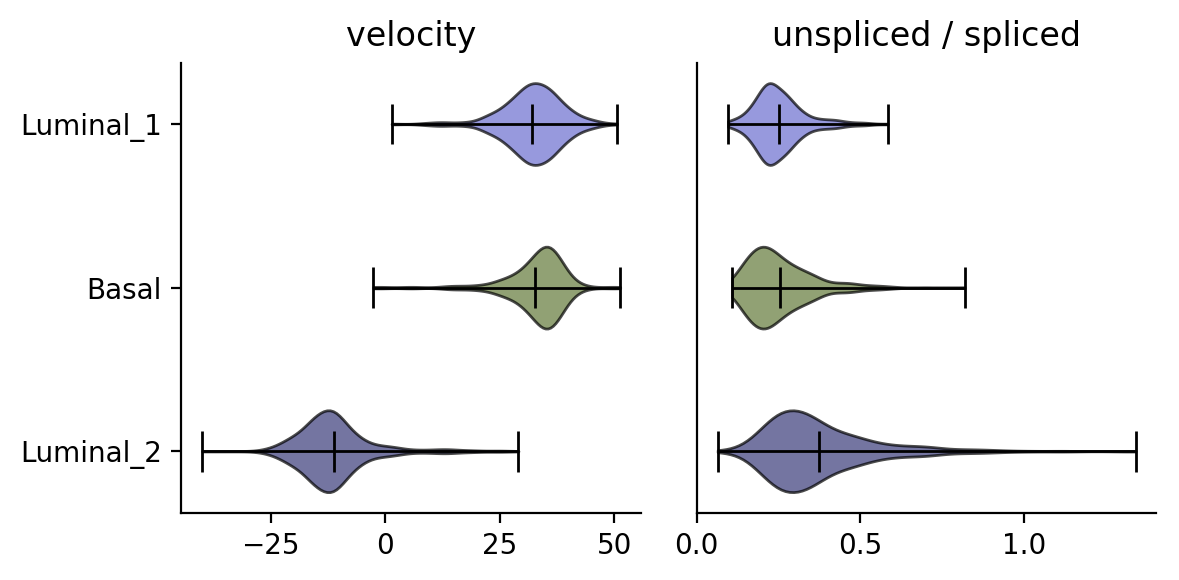

In [332]:
#compute the sum of velocities for all cells:
velocity_sums = np.array([np.sum(ind2.velocity[:,i]) for i in range(ind2.velocity.shape[1])])
#velocity_sums = np.array([np.sum(np.absolute(ind2.velocity[:,i])) for i in range(ind2.velocity.shape[1])])

#split this up into each cluster:
data = [velocity_sums[ind2.ca["ClusterName"] == cluster] for cluster in list(set(ind2.ca["ClusterName"]))]

fig, axes = plt.subplots(1,2, figsize=(6,3),dpi=200)

ax = plt.subplot(121)
violin = plt.violinplot(data, vert=False, showmeans=True);
for i, v in enumerate(violin['bodies']):
    v.set_facecolor(mycolors[i])
    v.set_edgecolor('k')
    v.set_alpha(0.7)

# change the line color from blue to black
for partname in ('cbars','cmins','cmaxes', 'cmeans'):
    vp = violin[partname]
    vp.set_edgecolor('k')
    vp.set_linewidth(1)

plt.yticks([], [])
plt.title("velocity")

#edit spines:
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
labels = [cluster for cluster in list(set(ind2.ca["ClusterName"]))]
plt.yticks([i for i in range(1, len(labels)+1)], labels);
plt.tight_layout()

ax = plt.subplot(122)
violin = plt.violinplot(ratios, vert=False, showmeans=True);
for i, v in enumerate(violin['bodies']):
    v.set_facecolor(mycolors[i])
    v.set_edgecolor('k')
    v.set_alpha(0.7)

# change the line color from blue to black
for partname in ('cbars','cmins','cmaxes', 'cmeans'):
    vp = violin[partname]
    vp.set_edgecolor('k')
    vp.set_linewidth(1)

plt.yticks([], [])
plt.title("unspliced / spliced")

#edit spines:
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(print_dir + "velocity_magnitudes.pdf")

# Pseudotime

In [333]:
#Wrap implementation
import rpy2.robjects as robj
from rpy2.robjects.packages import importr

def array_to_rmatrix(X):
    nr, nc = X.shape
    xvec = robj.FloatVector(X.transpose().reshape((X.size)))
    xr = robj.r.matrix(xvec, nrow=nr, ncol=nc)
    return xr

def principal_curve(X, pca=True):
    """
    input : numpy.array
    returns:
    Result::Object
        Methods:
        projections - the matrix of the projectiond
        ixsort - the order ot the points (as in argsort)
        arclength - the lenght of the arc from the beginning to the point
    """
    # convert array to R matrix
    xr = array_to_rmatrix(X)
    
    if pca:
        #perform pca
        t = robj.r.prcomp(xr)
        #determine dimensionality reduction
        usedcomp = max( sum( np.array(t[t.names.index('sdev')]) > 1.1) , 4)
        usedcomp = min([usedcomp, sum( np.array(t[t.names.index('sdev')]) > 0.25), X.shape[0]])
        Xpc = np.array(t[t.names.index('x')])[:,:usedcomp]
        # convert array to R matrix
        xr = array_to_rmatrix(Xpc)

    #import the correct namespace
    d = {'print.me': 'print_dot_me', 'print_me': 'print_uscore_me'}
    princurve = importr("princurve", on_conflict='warn')
    
    #call the function
    fit1 = princurve.principal_curve(xr)
    
    #extract the outputs
    class Results:
        pass
    results = Results()
    results.projections = np.array( fit1[0] )
    results.ixsort = np.array( fit1[1] ) - 1 # R is 1 indexed
    results.arclength = np.array( fit1[2] )
    results.dist = np.array( fit1[3] )
    
    if pca:
        results.PCs = np.array(xr) #only the used components
        
    return results

In [334]:
from sklearn.neighbors import NearestNeighbors
import igraph

nn = NearestNeighbors(50)
nn.fit(ind2.pcs[:,:4])
knn_pca = nn.kneighbors_graph(mode='distance')
knn_pca = knn_pca.tocoo()
G = igraph.Graph(list(zip(knn_pca.row, knn_pca.col)), directed=False, edge_attrs={'weight': knn_pca.data})
VxCl = G.community_multilevel(return_levels=False, weights="weight")
labels = np.array(VxCl.membership)

In [335]:
from numpy_groupies import aggregate, aggregate_np

In [336]:
pc_obj = principal_curve(ind2.pcs[:,:4], False)
pc_obj.arclength = np.max(pc_obj.arclength) - pc_obj.arclength
labels = np.argsort(np.argsort(aggregate_np(labels, pc_obj.arclength, func=np.median)))[labels]

/home/smudge/anaconda3/lib/python3.6/site-packages/rpy2/robjects/packages_utils.py:107: UserWarning: Conflict when converting R symbols in the package "princurve" to Python symbols: 
-lines_principal_curve -> lines.principal_curve, lines.principal.curve
- plot_principal_curve -> plot.principal_curve, plot.principal.curve
- points_principal_curve -> points.principal_curve, points.principal.curve
  warn(msg)


In [337]:
manual_annotation = {str(i):[i] for i in labels}
annotation_dict = {v:k for k, values in manual_annotation.items() for v in values }
clusters = np.array([annotation_dict[i] for i in labels])
colors20 = np.vstack((plt.cm.tab20b(np.linspace(0., 1, 20))[::2], plt.cm.tab20c(np.linspace(0, 1, 20))[1::2]))
#ind2.set_clusters(clusters, cluster_colors_dict={k:colors20[v[0] % 20,:] for k,v in manual_annotation.items()})
ind2.set_clusters(ind2.ca["ClusterName"])


In [338]:
k = 550
ind2.knn_imputation(n_pca_dims=n_comps,k=k, balanced=True,
                   b_sight=np.minimum(k*8, ind2.S.shape[1]-1),
                   b_maxl=np.minimum(k*4, ind2.S.shape[1]-1))

In [339]:
ind2.normalize_median()
ind2.fit_gammas(maxmin_perc=[2,95], limit_gamma=True)

In [340]:
ind2.normalize(which="imputed", size=False, log=True)
ind2.Pcs = np.array(ind2.pcs[:,:2], order="C")

In [341]:
ind2.predict_U()
ind2.calculate_velocity()
ind2.calculate_shift()
ind2.extrapolate_cell_at_t(delta_t=1)

In [342]:
ind2.estimate_transition_prob(hidim="Sx_sz", embed="Pcs", transform="log", psc=1,
                             n_neighbors=150, knn_random=True, sampled_fraction=1)

In [343]:
ind2.calculate_grid_arrows(smooth=0.9, steps=(25, 25), n_neighbors=200)


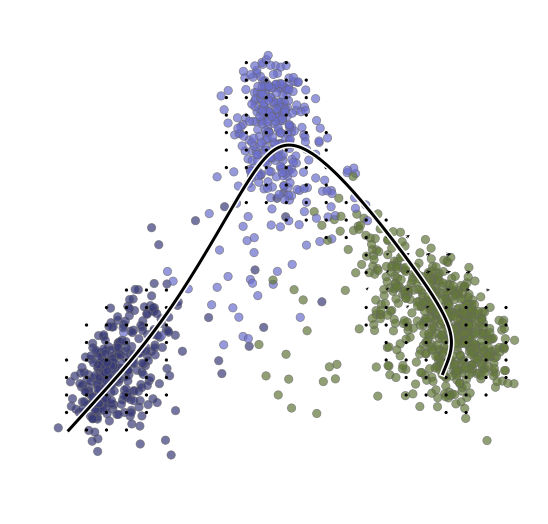

In [344]:
plt.figure(None,(9,9))
ind2.plot_grid_arrows(scatter_kwargs_dict={"alpha":0.7, "lw":0.7, "edgecolor":"0.4", "s":70, "rasterized":True},
                     min_mass=2.9, angles='xy', scale_units='xy',
                     headaxislength=2.75, headlength=5, headwidth=4.8, quiver_scale=0.35, scale_type="absolute")
plt.plot(pc_obj.projections[pc_obj.ixsort,0], pc_obj.projections[pc_obj.ixsort,1], c="w", lw=6, zorder=1000000)
plt.plot(pc_obj.projections[pc_obj.ixsort,0], pc_obj.projections[pc_obj.ixsort,1], c="k", lw=3, zorder=2000000)
plt.gca().invert_xaxis()
plt.axis("off")
plt.axis("equal");
plt.savefig(print_dir + "pseudotime.pdf")

In [345]:
pickle.dump(ind2, open("/data1/rna_velocity_data/ind9/ind9.hdf5", 'wb'))
